In [1]:
import numpy as np
from collections import defaultdict
import random
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import gzip
import csv
import matplotlib.pyplot as plt
import numpy as np
from random import sample

# strings mapping keys to values in dataset dict
# keys don't seem to make semantic sense so I added these
user_id = '1'
stream_id = '33842865744'
streamer_username = 'mithrain'
time_start = '154'
time_stop = '156'

# Dataset:

In [2]:
def readCSV(path):
    f = open(path, 'rt')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d

In [3]:
# read in twitch data 
full_dataset = list(readCSV("100k_a.csv"))

In [4]:
print(len(full_dataset))
print(full_dataset[0])

3051732
{'1': '1', '33842865744': '33846768288', 'mithrain': 'alptv', '154': '166', '156': '169'}


In [5]:
# dicts mapping user to streamer and vise versa 
user_to_streamer = defaultdict(list)
streamer_to_user = defaultdict(list)

# dicts tracking total watch time for users and streamers
streamer_to_time = defaultdict(int)
user_to_time = defaultdict(int)
user_to_wallclock = defaultdict(list)

# dicts tracking total number of streams watched
streamer_to_nstreams = defaultdict(int)
user_to_nstreams = defaultdict(int)
times = []

# dicts mapping stream id to streamer and vise versa
streamer_to_stream = defaultdict(list)
stream_to_streamer = defaultdict(str)
stream_times = defaultdict(list)
time_to_streamer = defaultdict(list)

# list for plotting statistics
users = []
streamers = []
avg_user_streamtimes = []
avg_streamer_streamtimes = []

userIDs = {}
streamerIDs = {}

# init various data structures
avg_time_watched = 0
for d in full_dataset:
    t_start = int(d[time_start])
    t_stop = int(d[time_stop])
    
    # track streamers currently streaming
    time_to_streamer[t_start].append(d[streamer_username])
    
    # calc time watched
    t = (t_stop - t_start) * 10
    streamer_to_nstreams[d[streamer_username]] += 1
    user_to_nstreams[d[user_id]] += 1
    
    # track start and stop times 
    times.append(t_start)
    times.append(t_stop)
    user_to_wallclock[d[user_id]].append((t_start, t_stop))
    
    # track total time viewing streams
    streamer_to_user[d[streamer_username]].append(d[user_id])
    streamer_to_time[d[streamer_username]] += t
    user_to_streamer[d[user_id]].append(d[streamer_username])
    user_to_time[d[user_id]] += t
    avg_time_watched += t
    
    # track stream info
    stream_to_streamer[d[stream_id]] = d[streamer_username]
    streamer_to_stream[d[streamer_username]].append(d[stream_id])
    stream_times[d[stream_id]].append(t_start)
    stream_times[d[stream_id]].append(t_stop)
    
    u = d[user_id]
    s = d[streamer_username]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not s in streamerIDs: streamerIDs[s] = len(streamerIDs)
    
max_time = max(times)
min_time = min(times)
print("Max time: " + str(max_time))
print("Min time: " + str(min_time))

Max time: 6148
Min time: 0


In [6]:
# streamer to ind
streamer_to_ind = defaultdict(int)
ind_to_streamer = defaultdict(str)

count = 0
for streamer in streamer_to_stream:
    streamer_to_ind[streamer] = count
    ind_to_streamer[count] = streamer
    
    count += 1

In [7]:
# info for each stream
stream_info = defaultdict(list)
for stream in stream_times:
    t = stream_times[stream]
    s_start = min(t)
    s_stop = max(t)
    
    # add streamer username, stream start time, stream end time 
    stream_info[stream].append(stream_to_streamer[stream])
    stream_info[stream].append(s_start)
    stream_info[stream].append(s_stop)

In [8]:
# time stamp info for each streamer
streamer_timesteps = defaultdict(set)
for streamer in streamer_to_stream:
    stream_id_list = streamer_to_stream[streamer]
    for stream in stream_id_list:
        info = stream_info[stream]
        start = info[1]
        stop = info[2]
        streamer_timesteps[streamer].add((start, stop))

In [9]:
# determine how many streams are running at each timestep
count_times = np.zeros((max_time + 1), dtype='int')
for stream in stream_info:
    s_start = stream_info[stream][1]
    s_stop = stream_info[stream][2]

    for i in range(s_start, s_stop + 1):
        count_times[i] += 1

In [10]:
avg_user_time = 0
for user in user_to_time:
    avg_user_time += user_to_time[user]
    
avg_streamer_time = 0
for streamer in streamer_to_time:
    avg_streamer_time += streamer_to_time[streamer]
    
avg_user_streamtime = 0
for user in user_to_nstreams:
    avg_user_streamtime += (user_to_time[user] / user_to_nstreams[user])
    
    # grab data for plotting
    users.append(user)
    avg_user_streamtimes.append(user_to_time[user] / user_to_nstreams[user])

avg_streamer_streamtime = 0
for streamer in streamer_to_nstreams:
    avg_streamer_streamtime += (streamer_to_time[streamer] / streamer_to_nstreams[streamer])
    
    # grab data for plotting
    streamers.append(streamer)
    avg_streamer_streamtimes.append(streamer_to_time[streamer] / streamer_to_nstreams[streamer])

In [11]:
print("Total number of users: " + str(len(user_to_time)))
print("Total number of streamers: " + str(len(streamer_to_time)))

Total number of users: 100000
Total number of streamers: 162625


In [12]:
print("Average time viewing a stream in total: " + str(avg_time_watched / len(full_dataset)))
print("Average absolute time a user watches: " + str(avg_user_time / len(user_to_time)))
print("Average absolute time a streamer is watched: " + str(avg_streamer_time / len(streamer_to_time)))

Average time viewing a stream in total: 31.420547413730958
Average absolute time a user watches: 958.8709
Average absolute time a streamer is watched: 589.6208455034589


In [13]:
print("Average instance time a user watches: " + str(avg_user_streamtime / len(user_to_nstreams)))
print("Average instance time a streamer is watched: " + str(avg_streamer_streamtime / len(streamer_to_nstreams)))

Average instance time a user watches: 30.364046319686075
Average instance time a streamer is watched: 26.9667813186417


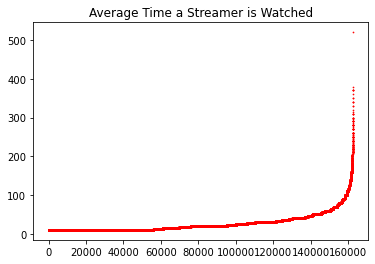

In [14]:
avg_streamer_streamtimes.sort()
nums = np.arange(0, len(streamers))
plt.title("Average Time a Streamer is Watched")
plt.scatter(nums, np.array(avg_streamer_streamtimes), s=0.5, c='r')
plt.gcf().savefig("Average Time a Streamer is Watched.png")
plt.show()

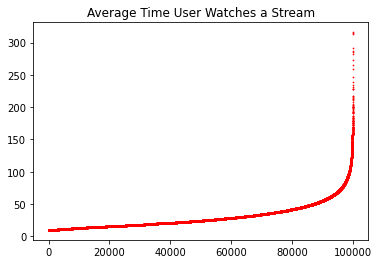

In [15]:
avg_user_streamtimes.sort()
nums = np.arange(0, len(users))
plt.title("Average Time User Watches a Stream")
plt.scatter(nums, np.array(avg_user_streamtimes), s=0.5, c='r')
plt.gcf().savefig("Average Time User Watches a Stream.png")
plt.show()

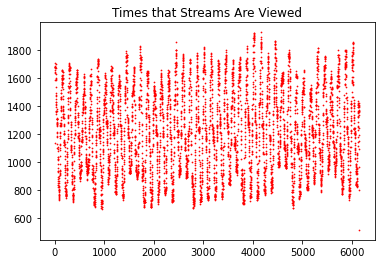

In [16]:
nums = np.arange(0, max_time + 1)
plt.title("Times that Streams Are Viewed")
plt.scatter(nums, count_times, s=0.5, c='r')
plt.gcf().savefig("Times that Streams Are Viewed")
plt.show()

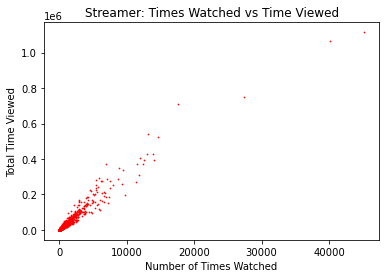

In [17]:
times_watched = []
time_viewed = []
for streamer in streamer_to_nstreams:
    times_watched.append(streamer_to_nstreams[streamer])
    time_viewed.append(streamer_to_time[streamer])
    
plt.title("Streamer: Times Watched vs Time Viewed")
plt.xlabel("Number of Times Watched")
plt.ylabel("Total Time Viewed")
plt.scatter(np.array(times_watched), np.array(time_viewed), s=0.5, c='r')
plt.gcf().savefig("Times that Streams Are Viewed")
plt.show()

### Baseline models:

The first baseline model we used was a popularity based model with a threshold of 0.5, similar to what we used in Assignment 1

In [18]:
# read in twitch data 
full_dataset = list(readCSV("100k_a.csv"))

In [19]:
for d in full_dataset:
    d[time_start] = int(d[time_start])
    d[time_stop] = int(d[time_stop])

In [20]:
full_dataset = sorted(full_dataset, key = lambda i: i[time_start])

for i in range(50000, 50010):
    print(full_dataset[i])

{'1': '1766', '33842865744': '33838962656', 'mithrain': 'tmemoryy', '154': 98, '156': 103}
{'1': '2244', '33842865744': '33839130544', 'mithrain': 'slrabbit99', '154': 98, '156': 132}
{'1': '2261', '33842865744': '33838438880', 'mithrain': 'rhdgurwns', '154': 98, '156': 99}
{'1': '2407', '33842865744': '33838522272', 'mithrain': 'anomally', '154': 98, '156': 99}
{'1': '2838', '33842865744': '33838478032', 'mithrain': 'strawberry_bbubbbu', '154': 98, '156': 99}
{'1': '3085', '33842865744': '33836858368', 'mithrain': 'osvaldohs', '154': 98, '156': 101}
{'1': '3132', '33842865744': '33838112224', 'mithrain': 'general_hs_', '154': 98, '156': 100}
{'1': '3664', '33842865744': '33838551136', 'mithrain': 'frizko94', '154': 98, '156': 100}
{'1': '3974', '33842865744': '33838254848', 'mithrain': 'khezu', '154': 98, '156': 99}
{'1': '3998', '33842865744': '33839089168', 'mithrain': 'raderaderader', '154': 98, '156': 102}


In [21]:
# Create train, valid, test sets with a 75/12.5/12.5 split
train = full_dataset[:int(.75*len(full_dataset))]
valid = full_dataset[int(.75*len(full_dataset)):int(.875*len(full_dataset))]
test = full_dataset[int(.875*len(full_dataset)):]

In [22]:
len(full_dataset) == len(train) + len(valid) + len(test)

True

In [23]:
streamers_train = set() # distinct streamers in train
user_to_streamer_train = defaultdict(set) # user to streamer map for train only
streamer_to_user_train = defaultdict(set) # streamer to user map for train only

# user iterations
user_interactions = defaultdict(list)

for t in train:
    user = t[user_id]
    streamer = t[streamer_username]
    streamers_train.add(streamer)
    user_to_streamer_train[user].add(streamer)
    streamer_to_user_train[streamer].add(user)
    user_interactions[user].append(t[streamer_username])

In [24]:
# init streamers list
streamers = [s for s in streamer_to_user_train]

In [25]:
# Return True if start is in the range of any of the stream times for the streamer
def time_in_range(start, timesteps):
    for timestep in timesteps:
        if start >= timestep[0] and start < timestep[1]:
#             print(str(start) + " " + str(timestep[0]) + " " + str(timestep[1]))
            return True
    return False

In [26]:
# Create new valid and test sets such that it consists of 50% positive and 50% negative
# Negative interactions imply unavailibility of streamer at interaction time 
negatives = [] # hold negative samples
count = 0
print(len(valid))

vneg_user_interactions = defaultdict(list)

for v in valid:
    # get list of streamers currently playing
    streamer_list = time_to_streamer[v[time_start]]
    
    # sample streamer that the user didn't watch
    streamer = v[streamer_username]
    while streamer == v[streamer_username]:
        streamer = random.choice(streamer_list)
        
    sample = {user_id: v[user_id], stream_id: '-1', streamer_username: streamer, time_start: v[time_start] , time_stop: v[time_start]}
    negatives.append(sample)
    
    vneg_user_interactions[v[user_id]].append(streamer)
    
#     count += 1
#     if count % 1000 == 0:
#         print(count)
    
print(len(valid))
valid.extend(negatives)
random.shuffle(valid)
print(len(valid))

381466
381466
762932


In [27]:
def most_popular(threshold, streamerTime, totalStreamers):
    mostPopular = [(streamerTime[x], x) for x in streamerTime]
    mostPopular.sort()
    mostPopular.reverse()
    
    return1 = set()
    count = 0
    
    print("Total streamers: " + str(totalStreamers))
    for ic, i in mostPopular:
        count += 1
        return1.add(i)
        if count > int(totalStreamers/(1/threshold)): break
            
    print("Return set length: " + str(len(return1)))
    
    return return1

In [28]:
# Return True if any of the most popular streamers are streaming at current timestep
def streamer_in_range(popular_streamers, start):
    for streamer in popular_streamers:
        timesteps = streamer_timesteps[streamer]
        
#         print(str(start) + " timesteps: " + str(timesteps))
        if time_in_range(start, timesteps):
            return True
    return False

In [29]:
totalStreamers = 0
streamerTime_t = defaultdict(int)
streamerTime_v = defaultdict(int)
for t in train:
    t_start = int(t[time_start])
    t_stop = int(t[time_stop])

#     streamerTime_t[t[streamer_username]] += (t_stop - t_start)
#     streamerTime_v[t[streamer_username]] += (t_stop - t_start)

    if streamerTime_t[t[streamer_username]] == 0:
        totalStreamers += 1
    
    streamerTime_t[t[streamer_username]] += 1
    streamerTime_v[t[streamer_username]] += 1

In [30]:
len(streamerTime_t) == totalStreamers

True

In [31]:
# Evaluate accuracy of baseline model on valid set
most_popular_50 = most_popular(0.01, streamerTime_t, totalStreamers) # most popular streamers using threshold of 50th percentile of popularity

# create validation baseline
actual_baseline_valid = [0 if v[stream_id] == '-1' else 1 for v in valid]

# create predicted baseline
pred_baseline_valid = []
count = 0
for v in valid:
    if v[streamer_username] not in most_popular_50:
        pred_baseline_valid.append(0)
    else:
        i_r = streamer_in_range(most_popular_50, int(v[time_start]))
        pred_baseline_valid.append(int(i_r))
        
#     print(pred_baseline_valid[-1])
        
    count += 1
    if count % 100000 == 0: 
        print(count)
        
print(pred_baseline_valid[:30])
print(actual_baseline_valid[:30])

baseline_acc_valid = accuracy_score(actual_baseline_valid, pred_baseline_valid)
print('Accuracy of baseline model on validation set: {}'.format(baseline_acc_valid))

Total streamers: 137586
Return set length: 1376
100000
200000
300000
400000
500000
600000
700000
[0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]
Accuracy of baseline model on validation set: 0.5009856710689813


Acc with thresh of 0.75: 0.8666.
Acc with thresh of 0.5: 0.7476.
Acc with thresh of 0.25: 0.6266.

In [32]:
def Jaccard(s1, s2, acc=True):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    
    return numer/ denom

In [33]:
def calc_acc(pred, act):
    avg = 0
    for i in range(len(pred)):
        avg += Jaccard(pred[i], act[i])
        
    return (avg / len(pred))

The second baseline model we create is a Jaccard similarity based model. thresh = 0.01 => 0.872. 

In [57]:
def predict_watched(user_id, streamer_username, time_start, threshold):
    # assure that streamer is streaming at time of interaction
    timesteps = streamer_timesteps[streamer_username]
    if not time_in_range(time_start, timesteps):
        return 0
    
    # at this point, streamer is streaming at time of interaction
    similarities = []
    for streamer in user_to_streamer_train[user_id]:
        if streamer_username == streamer: continue
        similarities.append(Jaccard(set(streamer_to_user_train[streamer_username]), set(streamer_to_user_train[streamer]), acc=False))
    
    if len(similarities) == 0 or max(similarities) < threshold:
        return 0
    return 1

In [58]:
jacc_preds = []
thresh = 0.01

actual_baseline_valid = [0 if v[stream_id] == '-1' else 1 for v in valid]

count = 0
for v in valid:
    jacc_preds.append(predict_watched(v[user_id], v[streamer_username], int(v[time_start]), thresh))
    
    count += 1
    if count % 100000 == 0: 
        print(count)
jacc_acc = accuracy_score(actual_baseline_valid, jacc_preds)
print('Accuracy of Jaccard similarity model: {}'.format(jacc_acc))

100000
200000
300000
400000
500000
600000
700000
Accuracy of Jaccard similarity model: 0.8723608394981466


First model we try is the FPMC model

In [34]:
import tensorflow as tf

num_users = len(user_to_time)
num_streamers = len(streamer_to_time)

class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([num_streamers],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([num_users,K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([num_streamers,K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([num_streamers,K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([num_streamers,K],stddev=0.001))
        
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        u = userIDs[u]
        i = streamerIDs[i]
        j = streamerIDs[j]
        
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

In [35]:
def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            u,i,j = random.choice(interactions) # positive sample
            
            # negative sample
            k = random.choice(streamers) 
            while k in user_to_streamer_train[u]:
                k = random.choice(streamers)
                
            sampleU.append(userIDs[u])
            sampleI.append(streamerIDs[i])
            sampleJ.append(streamerIDs[j])
            sampleK.append(streamerIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [36]:
def testingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            u,i,j = random.choice(interactions) # positive sample
            
            # negative sample
            k = random.choice(streamers) 
            while k in user_to_streamer_train[u]:
                k = random.choice(streamers)
                
            sampleU.append(userIDs[u])
            sampleI.append(streamerIDs[i])
            sampleJ.append(streamerIDs[j])
            sampleK.append(streamerIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
    return loss.numpy()

In [37]:
# create list to train with 
train_iWithPrevious = []
for u in user_interactions:
    lastItem = 'dummy'
    
    for s in user_interactions[u]:
        train_iWithPrevious.append((u,s,lastItem))
        lastItem = s

In [38]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [41]:
modelFPMC_a = FPMC(5, 0.00001, UI=1, IJ=1)

In [42]:
for i in range(100):
    obj = trainingStep(modelFPMC_a, train_iWithPrevious)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.37261724
iteration 20, objective = 0.37666816
iteration 30, objective = 0.3621567
iteration 40, objective = 0.35237893
iteration 50, objective = 0.3444966
iteration 60, objective = 0.34426457
iteration 70, objective = 0.33911428
iteration 80, objective = 0.33840775
iteration 90, objective = 0.3355483
iteration 100, objective = 0.33703178


In [43]:
# user iterations
v_user_interactions = defaultdict(list)

for v in valid:
    user = v[user_id]
    v_user_interactions[user].append(v[streamer_username])

In [44]:
# create list to eval valid with 
valid_iWithPrevious = []
for v in v_user_interactions:
    lastItem = 'dummy'
    
    for s in v_user_interactions[v]:
        valid_iWithPrevious.append((v,s,lastItem))
        lastItem = s

In [45]:
interactionsValidPerUser = defaultdict(set)
itemSet = set()
for u,i,j in valid_iWithPrevious:
    interactionsValidPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)

In [ ]:
# # create neg list to eval valid with 
# neg_valid_iWithPrevious = []
# for v in vneg_user_interactions:
#     lastItem = 'dummy'
    
#     for s in vneg_user_interactions[v]:
#         neg_valid_iWithPrevious.append((v,s,lastItem))
#         lastItem = s

In [46]:
def AUCu(model, u, N):
    win = 0
    
    if N > len(interactionsValidPerUser[u]):
        N = len(interactionsValidPerUser[u])
        
    positive = random.sample(interactionsValidPerUser[u],N)
    negative = random.sample(itemSet,N)
    
    for (i,j),k in zip(positive,negative):
        sp = model.predict(u, i, j).numpy()
        sn = model.predict(u, k, j).numpy()
        if sp > sn:
            win += 1
            
    return win/N

In [47]:
def AUC(model):
    av = []
    count = 0
    for u in interactionsValidPerUser:
        av.append(AUCu(model, u, 1))
        
        count += 1
        if count % 1000 == 0: 
            print(count)
    return sum(av) / len(av)

In [48]:
print("AUC = " + str(AUC(modelFPMC_a)))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
AUC = 0.8605981346018424


In [49]:
negatives = [] # hold negative samples
count = 0
print(len(test))

for t in test:
    # get list of streamers currently playing
    streamer_list = time_to_streamer[t[time_start]]
    
    # sample streamer that the user didn't watch
    streamer = t[streamer_username]
    while streamer == t[streamer_username]:
        streamer = random.choice(streamer_list)
        
    sample = {user_id: t[user_id], stream_id: '-1', streamer_username: streamer, time_start: t[time_start] , time_stop: t[time_start]}
    negatives.append(sample)
test.extend(negatives)
random.shuffle(test)
print(len(test))

381467
762934


In [50]:
# user iterations
t_user_interactions = defaultdict(list)

for t in test:
    user = t[user_id]
    t_user_interactions[user].append(t[streamer_username])

In [51]:
# create list to eval test with 
test_iWithPrevious = []
for t in t_user_interactions:
    lastItem = 'dummy'
    
    for s in t_user_interactions[t]:
        test_iWithPrevious.append((t,s,lastItem))
        lastItem = s

In [52]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for u,i,j in test_iWithPrevious:
    interactionsTestPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)
print(len(interactionsTestPerUser))

68441


In [53]:
def t_AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
        
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet,N)
    
    for (i,j),k in zip(positive,negative):
        sp = model.predict(u, i, j).numpy()
        sn = model.predict(u, k, j).numpy()
        if sp > sn:
            win += 1
            
    return win/N

In [54]:
def t_AUC(model):
    av = []
    count = 0
    
    for u in interactionsTestPerUser:
        av.append(t_AUCu(model, u, 1))
        
        count += 1
        if count % 1000 == 0: 
            print(count)
    return sum(av) / len(av)

In [55]:
print("AUC = " + str(t_AUC(modelFPMC_a)))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
AUC = 0.8619102584707997
